## Converting ITSLive and MEaSUREs xarray data sets to a tif raster 

In [1]:
import xarray as xr
from configobj import ConfigObj
import rasterio
import rioxarray
import os
import sys
import numpy as np

In [2]:
def crop_velocity_data_to_extend(dvel, extend,
                                 return_coords=False,
                                 return_indexes=False,
                                 return_xarray=False):
    """
    Returns a xarray.Dataset crop to the given mesh
    extent
    :param
        dvel: xarray.Dataset to crop
        extend: extend to crop the data to
        given as a dictionary with the form:
        e.g. {'xmin': -1609000.0, 'xmax': -1381000.0,
              'ymin': -718450.0, 'ymax': -527000.0}
        return_coords: Bool to return x and y coordinates (default is False)
        return_indexes: Bool to return indexes of the cropped array (default is False)
        return_xarray: Bool to return the result as an xarray (default is False)
    :return
        see function below
    """

    # Processing vel data
    x_coords = dvel.x.data
    y_coords = dvel.y.data

    x_inds = np.where((x_coords >= extend["xmin"]) & (x_coords <= extend["xmax"]))[0]
    y_inds = np.where((y_coords >= extend["ymin"]) & (y_coords <= extend["ymax"]))[0]

    dv = dvel.isel(x=x_inds, y=y_inds)

    if return_xarray and return_indexes:
        return dv, x_inds, y_inds
    elif return_xarray:
        return dv
    elif return_coords:
        return dv.data, dv.x.data, dv.y.data
    else:
        return dv.data

In [3]:
MAIN_PATH = os.path.expanduser('~/co_registration_velfiles/')
sys.path.append(MAIN_PATH)

# Load configuration file for more order in paths
config = ConfigObj(os.path.join(MAIN_PATH, 'config.ini'))

In [4]:
config

ConfigObj({'itslive': '/home/brecinos/smith_glacier/input_data/itslive/', 'measures_cloud': '/home/brecinos/smith_glacier/input_data/MEASURES/Antarctica_ice_velocity_2013_2014_1km_v01.nc', 'measures_cloud_intrp': '/home/brecinos/smith_glacier/input_data/MEASURES/measures_in_itslive_grid.nc'})

In [5]:
path_itslive = os.path.join(MAIN_PATH,
                                config['itslive'])
file_names = os.listdir(path_itslive)

paths_itslive = []

for f in file_names:
    paths_itslive.append(os.path.join(path_itslive, f))

print(paths_itslive[-1])

/home/brecinos/smith_glacier/input_data/itslive/ANT_G0240_2014.nc


In [6]:
path_measures = config['measures_cloud_intrp']
path_measures

'/home/brecinos/smith_glacier/input_data/MEASURES/measures_in_itslive_grid.nc'

## Read the original ITSLive data set with rioxarray to preserve proj

In [7]:
rds = rioxarray.open_rasterio(paths_itslive[-1])

In [13]:
rds.Polar_Stereographic.attrs

{'crs_wkt': 'PROJCS["WGS 84 / Antarctic Polar Stereographic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",-71],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3031"]]',
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356752.314245179,
 'inverse_flattening': 298.257223563,
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': 0.0,
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'horizontal_datum_name': 'World Geodetic System 1984',
 'projected_crs_name': 'WGS 84 / Antarctic Polar Stereographic',
 'grid_mapping_name': 'polar_ste

## Read the MEaSUREs data set interpolated to ITSLive grid 

In [14]:
dm = xr.open_dataset(path_measures)

In [15]:
dm

<xarray.Dataset>
Dimensions:  (x: 22896, y: 18392)
Coordinates:
  * x        (x) float32 -2.678e+06 -2.678e+06 ... 2.816e+06 2.817e+06
  * y        (y) float32 2.26e+06 2.259e+06 2.259e+06 ... -2.154e+06 -2.154e+06
Data variables:
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
    vx       (y, x) float32 ...
    vy       (y, x) float32 ...
    std_vx   (y, x) float32 ...
    std_vy   (y, x) float32 ...
Attributes:
    author:       B.M Recinos
    author_info:  The University of Edinburgh

Crop MEaSUREs data to the smith glacier domain

In [16]:
smith_bbox = {'xmin': -1609000.0,
              'xmax': -1381000.0,
              'ymin': -718450.0,
              'ymax': -527000.0}

vxm = dm.vx
vym = dm.vy
std_vxm = dm.std_vx
std_vym = dm.std_vy

vxm_s = crop_velocity_data_to_extend(vxm, smith_bbox, return_xarray=True)
vym_s = crop_velocity_data_to_extend(vym, smith_bbox, return_xarray=True)
vxm_err_s = crop_velocity_data_to_extend(std_vxm, smith_bbox, return_xarray=True)
vym_err_s = crop_velocity_data_to_extend(std_vym, smith_bbox, return_xarray=True)

Crop ITSLive data to the smith glacier domain

In [17]:
vxi = rds.vx
vyi = rds.vy
vxi_err = rds.vx_err
vyi_err = rds.vy_err
count = rds['count']

std_vxi = (count ** (1/2)) * vxi_err
std_vyi = (count ** (1/2)) * vyi_err 

In [19]:
vxi_s = crop_velocity_data_to_extend(vxi, smith_bbox, return_xarray=True)
vyi_s = crop_velocity_data_to_extend(vyi, smith_bbox, return_xarray=True)
vxi_err_s = crop_velocity_data_to_extend(std_vxi, smith_bbox, return_xarray=True)
vyi_err_s = crop_velocity_data_to_extend(std_vyi, smith_bbox, return_xarray=True)

In [24]:
vxi_s.Polar_Stereographic.attrs

{'crs_wkt': 'PROJCS["WGS 84 / Antarctic Polar Stereographic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",-71],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3031"]]',
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356752.314245179,
 'inverse_flattening': 298.257223563,
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': 0.0,
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'horizontal_datum_name': 'World Geodetic System 1984',
 'projected_crs_name': 'WGS 84 / Antarctic Polar Stereographic',
 'grid_mapping_name': 'polar_ste

In [ ]:
#dv.Polar_Stereographic.spatial_proj4

## Lets add this projection as attribute for each variable in the ITSLive data set

In [ ]:
#vxi_s.attrs['pyproj_srs'] = dv.Polar_Stereographic.spatial_proj4

In [ ]:
#vyi_s.attrs['pyproj_srs'] = dv.Polar_Stereographic.spatial_proj4

In [ ]:
#vxi_err_s.attrs['pyproj_srs'] = dv.Polar_Stereographic.spatial_proj4

In [ ]:
#vyi_err_s.attrs['pyproj_srs'] = dv.Polar_Stereographic.spatial_proj4

In [29]:
vxi_s.rio.to_raster("vx_smith_itslive.tif")

In [30]:
vyi_s.rio.to_raster("vy_smith_itslive.tif")

In [31]:
vxm_s.rio.to_raster("vx_smith_measures.tif")

In [32]:
vym_s.rio.to_raster("vy_smith_measures.tif")

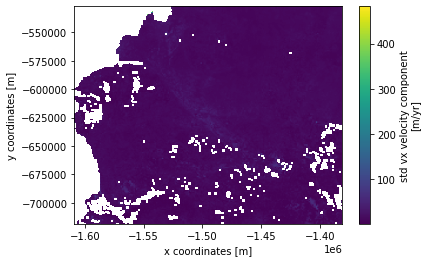

In [33]:
vxm_err_s.plot()

In [34]:
vxm_err_s.rio.to_raster("stdvx_smith_measures.tif")

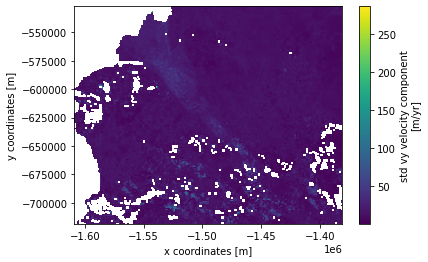

In [35]:
vym_err_s.plot()

In [36]:
vym_err_s.rio.to_raster("stdvy_smith_measures.tif")